# Pricing Test 

#### Problem statement: 

Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of  Product has decided to run a test increasing the price. She hopes that this would increase revenue. 

In the experiment, 66% of the users have seen the old price (\\$39), while a random sample of 33% users a higher price (\\$59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

- Should the company sell its software for \\$39 or \\$59?

- The VP of Product is interested in having a holistic view into user behavior, especially
focusing on actionable insights that might increase conversion rate. What are your main
findings looking at the data?

- [Bonus] The VP of Product feels that the test has been running for too long and he should
have been able to get statistically significant results in a shorter time. Do you agree with
her intuition? After how many days you would have stopped the test? Please, explain
why.

In [294]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import norm 

In [12]:
user = pd.read_csv('user_table.csv')
result = pd.read_csv('test_results.csv')

In [4]:
user.head(3)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39


In [13]:
result.head(3)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0


### 1. Data Processing and Cleaning

In [202]:
print('user_table:\t', user['user_id'].unique().shape)
print('test_results:\t', result['user_id'].unique().shape)

user_table:	 (275616,)
test_results:	 (316800,)


In [203]:
# merges two dataset 
df = result.merge(user, on = 'user_id', how = 'left')

Some possible data quality issues are: visitors in the test group are shown with \\$39 and visitors in the control group are shown with \\$59. Let's take a look at this issue.

In [204]:
df[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

We will remove the problematic data since they are only a small portion of the dataset.

In [207]:
df = df[((df['test'] == 1) & (df['price'] == 59)) | ((df['test'] == 0) & (df['price'] == 39))]

We will create a new column called `Revenue`, which is how much the company gain from each user's purchase. 

In [210]:
df['revenue'] = df['converted'] * df['price']

### 2. Inital Data Understanding

As the first step of analysis, we want to understand the demographics of site visitors by looking at what source they come from, what device and what operative system they use. 

- ####  Volume of visitors by source

In [283]:
groupby_source = df.groupby('source').size().reset_index(name = 'number_of_visitors').sort_values(by = 'number_of_visitors', ascending = False)
groupby_source['percent_of_visitors(%)'] = 100 * groupby_source['number_of_visitors'] / sum(groupby_source['number_of_visitors'])
groupby_source.head(5)

,source,number_of_visitors,percent_of_visitors(%)
5,direct_traffic,60272,19.047198
1,ads-google,59342,18.753298
3,ads_facebook,53355,16.861283
4,ads_other,29826,9.425632
8,seo-google,23148,7.315246


Based on the barplot above, we observe that most of the visitors come to the site by `direct_traffic`, `google ads` and `facebook ads`. 

- #### Volume of visitors by device

In [295]:
groupby_device = df.groupby('device').size().reset_index(name = 'number_of_visitors').sort_values(by = 'number_of_visitors', ascending = False)
groupby_device['percent_of_visitors(%)'] = 100 * groupby_device['number_of_visitors'] / sum(groupby_device['number_of_visitors'])
groupby_device

,device,number_of_visitors,percent_of_visitors(%)
0,mobile,186267,58.864222
1,web,130168,41.135778


We observe that most of the visitors come to the site by `mobile`. 

- #### Duration of the experiment 

In [286]:
print('The experiment started on', df['timestamp'].min(), 'and ended on', df['timestamp'].max())

The experiment started on 2015-03-02 00:04:12 and ended on 2015-05-31 23:59:45


We can see that the experiment has run for roughly 2 months. 

### 3. Analysis of the result of A/B testing

- #### Overall difference in conversion rate 

In [304]:
test = df[df['test'] == 1]
control= df[df['test'] == 0]
test_conversion = round(len(test[test['converted'] == 1]) / len(test), 4)
control_conversion = round(len(control[control['converted'] == 1]) / len(control), 4)
pd.DataFrame(data = {'visitors' : [len(test), len(control)],
                     'converts': [len(test[test['converted'] == 1]), len(control[control['converted'] == 0])],
                    'conversion_rate': [test_conversion, control_conversion]}, index = ['test group ($59)', 'control group ($39)'])

,visitors,converts,conversion_rate
test group ($59),113918,1772,0.0156
control group ($39),202517,198487,0.0199


The overall conversion rate for control group is higher than that of test group. We want to further break down the difference in conversion rate by several other factors like `source`, `device` and `user demographics` to see if this still holds true. 

- #### Difference in conversion rate by source

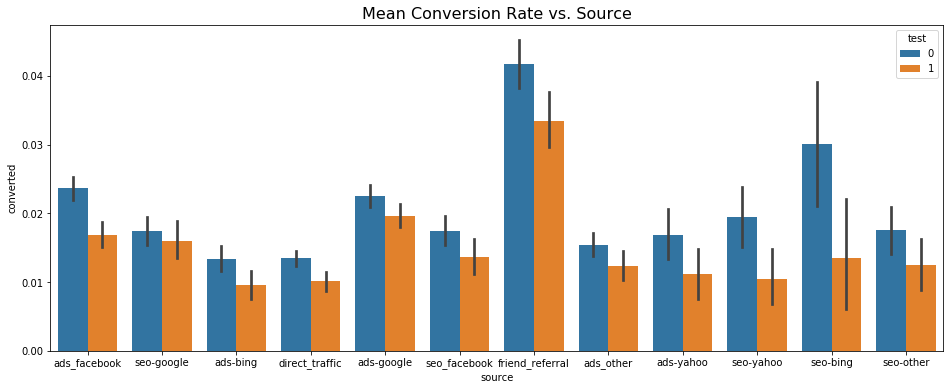

In [222]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=df, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

From the barplot above, the converion rate for control group is consistently higher than that of test group across all sources. 

Interestingly, the conversion rate in `friend referral` channel is particularly higher than all the other sources. 

- #### Difference in conversion rate by device

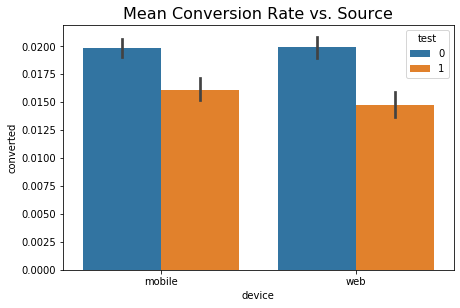

In [224]:
fig, ax = plt.subplots(figsize=(7, 4.5))
sns.barplot(x='device', y='converted', hue='test', data=df, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

The conversion rate for control group is higher than that of test group regardless of what device the users are on. 

Unlike the impact of `source` on conversion rate, the influence of `device` on conversion rate is not significant.  

- #### Difference in conversion rate by operative system. 

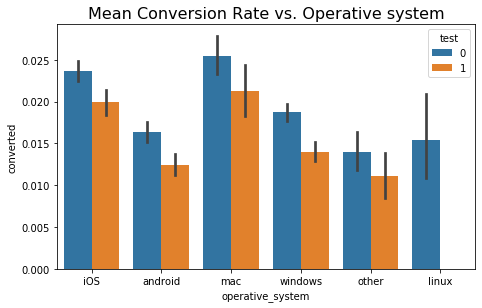

In [227]:
fig, ax = plt.subplots(figsize=(7.5, 4.5))
sns.barplot(x='operative_system', y='converted', hue='test', data=df, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative system', fontsize=16)
plt.show()

Among all the operative systems, MAC users have the highest conversion rate. 

For Linux users, the conversion rate in the test group is 0 (there are 1926 Linux users in the test group).  Further analysis is encouraged to understand why users on Linux have such low conversion rates. There might be some compatibility issues with Linux system which caused troubles for the users to complete their purchase. 

### Conclusion & Recommendations 

Based on my analysis above, the company should not sell the software at \\$59 because the results have shown that the conversion rate in the control group is higher than that in the test group, and this is true for all the devices, sources and operative systems. 

For `source`, friend referral is proven to have the highest conversion rate in both test and control group. With that being said, the company should focus on developing friend referral rewards program in order to maximize the benefits it could gain from friends' referral. 

For `device`, both mobile and web have similar converion rate and thus the choice of device has no significant impact on users' purchase. 

For `operative system`, MAC users have the highest converion rate. Linux users in the control group have 0 conversion rate and it's important to conduct further analysis using additional data to understand why Linux users have such low conversion rates. 